# Interpolate Data from Polar Grid to Data in Cartesian Grid

**Assumption**

Data are provided on a polar grid. A data point is described by its radius $r$ and its angle $\theta$.

The range of $r$ shall be $-R \le r \le R$ and the range of angle $\theta$  shall be $0 \le \theta \lt \pi$.

The range of $r$ shall be discretized by $N_r$ values $r[n_r]$ with equidistant spacing $\Delta R$. $N_r$ shall be an odd number. Then discretized radii are expressed by.

$$\begin{gather}
r[n_r] = -R + n_r \cdot \Delta R \\
0 \le n_r \le N_r - 1   \ \  N_r \ odd \\
r[n_r=0] = -R \\
r\left[\frac{N_r - 1}{2}\right] = 0  \\
r[N_r - 1] = R
\end{gather}
$$

The range of $\theta$ shall be discretized by $N_{\theta}$ values $\theta[n_{\theta}]$ with equistant spacing $\Delta \theta$. The discretized angles are expressed by:

$$\begin{gather}
\theta[n_{\theta}] = n_{\theta} \cdot \Delta \theta \\
0 \le n_{\theta} \le N_{\theta} - 1 \\
\theta[n_{\theta}=0] = 0 \\
\theta[n_{\theta}=N_{\theta} - 1] = \pi
\end{gather}
$$

The polar data points shall be interpolated on a cartesian data grid defined in the $u,\ v$ plane.

Ranges for $u$ and $v$ are:

$$\begin{gather}
-R \lt -U \le u \le U \lt R\\
-R \lt -U \le v \le U \lt R
\end{gather}
$$

With this setting of permissible ranges we do not run in to problems when interpolating cartesian data from polar data. For interpolation to work consistently we must have exactly 4 polar data as *neighbor* of a cartesian data point we want to interpolate.

The figure below shows the ranges where polar- and cartesian data are defined.

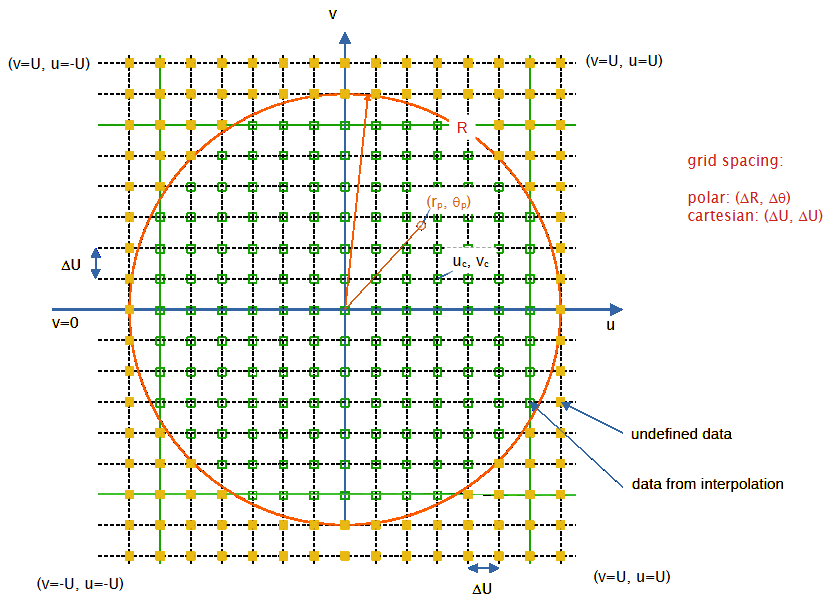



## Polar Data (Playground)

Define properties of a lookup table with polar data.

Using only data of quadrant `Q1`.

In [1]:
import os, sys
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

## Cartesian Data


Currently we consider only the first quadrant of the $u,v$ frequency plane. 





### Trying 2D interpolation from Numpy / Scipy

**motivation**

A sinogram represents projection values in a polar coordinate system. To reconstruct the image from its projections using the `Fourier slice theorem` the transformed projections must presented in a cartesian coordinate system before applying the inverse 2D Fourier transform to reconstract the image.

**workflow**

1) load sinogram and display it

2) compute data structure with transformed projection

3) define a grid of cartesian coordinates

4) interpolate from polar to cartesian coordinates

5) reconstruct an approximate version of the image

In [2]:
fname_sino = './sinograms/sinogram_stripes.npz'
npzData = np.load(fname_sino)
print(f"npzData.files: {npzData.files}")

# get data and initialize filtered sinogram
N_theta = npzData['N_theta']
theta_vec_deg = npzData['theta_vec_deg']
t_vec = npzData['t_vec']
sinogram = npzData['sinogram']
np.nan_to_num(sinogram, copy=False);

proj1 = sinogram[0, :]
proj2 = sinogram[-1, :]
dft_proj1 = np.fft.fft(proj1)
dft_proj2 = np.fft.fft(proj2)
inv_dft_proj1 = np.real(np.fft.ifft(dft_proj1))

# check for symmetry
N_t = len(t_vec)
N_t_mid = N_t // 2
print(f"len(t_vec): {N_t}; N_t_mid: {N_t_mid}; t_vec[N_t_mid]: {t_vec[N_t_mid]}")
print(f"dft_proj1[10]: {dft_proj1[10]}; dft_proj1[-10]: {dft_proj1[-10]}")

npzData.files: ['N_theta', 'theta_vec_deg', 't_vec', 'sinogram']
len(t_vec): 501; N_t_mid: 250; t_vec[N_t_mid]: 0.0
dft_proj1[10]: (-26240.15331450643+15406.853232109592j); dft_proj1[-10]: (-26240.153314506417-15406.853232109614j)


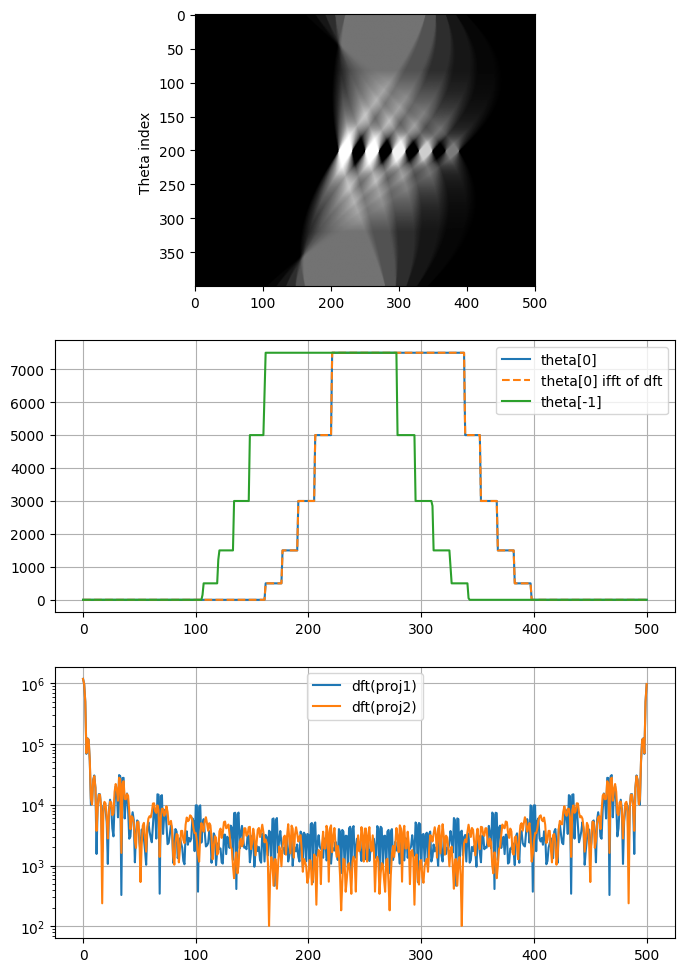

In [3]:
fig1 = plt.figure(1, figsize=[8, 12])

ax_f11 = fig1.add_subplot(3, 1, 1)
# plot of sinogram
ax_f11.imshow(sinogram, cmap='Greys_r' )
ax_f11.set_ylabel('Theta index ')

ax_f12 = fig1.add_subplot(3, 1, 2)
# plot of projection
ax_f12.plot(proj1, label='theta[0]')
ax_f12.plot(inv_dft_proj1, linestyle='--', label='theta[0] ifft of dft')
ax_f12.plot(proj2, label='theta[-1]')

ax_f12.grid(True)
ax_f12.legend()

ax_f13 = fig1.add_subplot(3, 1, 3)
# plot of dft
ax_f13.semilogy(np.abs(dft_proj1), label='dft(proj1)')
ax_f13.semilogy(np.abs(dft_proj2), label='dft(proj2)')
ax_f13.grid(True)
ax_f13.legend()



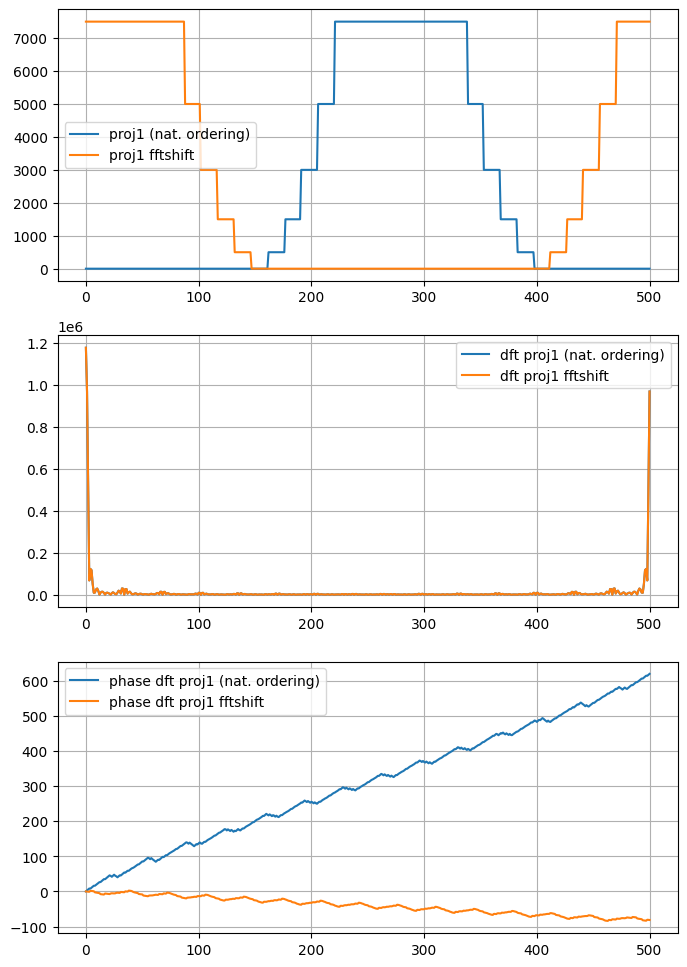

In [13]:
fig2 = plt.figure(2, figsize=[8, 12])

ax_f21 = fig2.add_subplot(3, 1, 1)
ax_f21.plot(proj1, label='proj1 (nat. ordering)')
ax_f21.plot(np.fft.fftshift(proj1), label='proj1 fftshift')
ax_f21.grid(True)
ax_f21.legend()

ax_f22 = fig2.add_subplot(3, 1, 2)
ax_f22.plot(np.abs(np.fft.fft(proj1)), label='dft proj1 (nat. ordering)')
ax_f22.plot(np.abs(np.fft.fft(np.fft.fftshift(proj1))), label='dft proj1 fftshift')
ax_f22.grid(True)
ax_f22.legend()

ax_f23 = fig2.add_subplot(3, 1, 3)
ax_f23.plot(np.unwrap(np.angle(np.fft.fft(proj1))), label='phase dft proj1 (nat. ordering)')
ax_f23.plot(np.unwrap(np.angle(np.fft.fft(np.fft.fftshift(proj1)))), label='phase dft proj1 fftshift')
ax_f23.grid(True)
ax_f23.legend()

## DFT of Sinogram

For each angle $\theta$ only DFT values for positive frequencies (starting at 0) need be stored. This is because of the hermitean symmetry of the DFT of a real valued projection. The DFT values for a negative frequency is obtained from the *conjugate complex* of the corresponding value at the positive frequency.

In [15]:
# initalise
# index largest of positive frequency
N_dft_p = (N_t - 1) // 2
# memory allocation 
dft_sinogram = np.zeros( (N_theta, N_dft_p + 1), dtype=np.complex64)
# postive frequency grid
f_grid_p = np.arange(N_dft_p+1)

# iterate over projection angle 
for n_theta in range(N_theta):
    projection_fftshift = np.fft.fftshift(sinogram[n_theta, :])
    # store dft of projection for frequencies >= 0
    dft_sinogram[n_theta] = np.fft.fft(projection_fftshift)[0:N_dft_p + 1]
    

### doing some checks ...

checking DFT of projection graphically ...


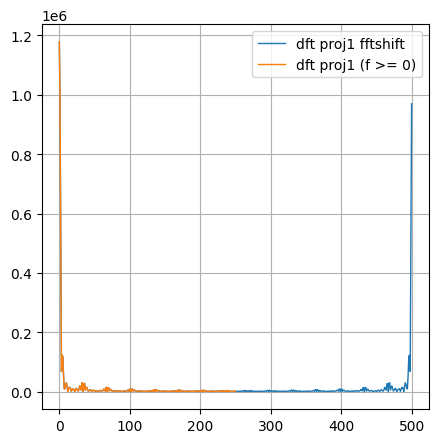

In [22]:
fig3 = plt.figure(3, figsize=[5, 5])

ax_f31 = fig3.add_subplot(1, 1, 1)
ax_f31.plot(np.abs(np.fft.fft(np.fft.fftshift(proj1))), linewidth=1, label='dft proj1 fftshift')
ax_f31.plot(f_grid_p, np.abs(dft_sinogram[0,:]), linewidth=1, label='dft proj1 (f >= 0)')
ax_f31.grid(True)
ax_f31.legend()

In [33]:
# setting up the interpolator
interp_sino = RegularGridInterpolator( (theta_vec_deg, f_grid_p), dft_sinogram, method='linear', bounds_error=False, fill_value=0)

# allocating storage for 1st quadrant (u >= 0, v > = 0)
dft_Q1 = np.zeros( (N_dft_p + 1, N_dft_p + 1), dtype=np.complex64)

# allocating storage for 2nd quadrant (u <= 0, v > = 0)
dft_Q2 = np.zeros( (N_dft_p + 1, N_dft_p), dtype=np.complex64)

In [35]:
# creating data vectors for interpolation

# 1st quadrant
for k in range(N_dft_p + 1):
    # row wise 
    offset = k  # u >= 0; v >= 0
    # a new row
    o_grid = f_grid_p + 1j*offset
    # interpolation vectors (radius / angle)
    r_vec = np.abs(o_grid)
    angle_vec = np.angle(o_grid, deg=True)
    # doing interpolation
    dft_cartesian_vec = interp_sino( (angle_vec, r_vec) )
    dft_Q1[k,:] = dft_cartesian_vec

# 2nd quadrant
for k in range(N_dft_p):
    # row wise ; starting at first row 
    offset = k + 1  # u >= 0; v >= 0
    # a new row
    o_grid = -np.flip(f_grid_p[1:]) + 1j*offset
    # interpolation vectors (radius / angle)
    r_vec = np.abs(o_grid)
    angle_vec = np.angle(o_grid, deg=True)
    # doing interpolation
    dft_cartesian_vec = interp_sino( (angle_vec, r_vec) )
    dft_Q2[k+1,:] = dft_cartesian_vec

# correct row 0 of 2nd quadrant
dft_Q2[0,:] = np.flip(np.conjugate(dft_Q1[0, 1:]))

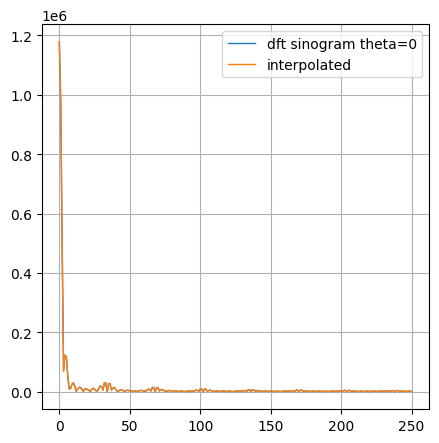

In [29]:
fig4 = plt.figure(4, figsize=[5, 5])

ax_f41 = fig4.add_subplot(1, 1, 1)
ax_f41.plot(f_grid_p, np.abs(dft_sinogram[0,]), linewidth=1, label='dft sinogram theta=0')
ax_f41.plot(f_grid_p, np.abs(dft_Q1[0,:]), linewidth=1, label='interpolated (theta=0)')
ax_f41.grid(True)
ax_f41.legend()

### Setting up the image matrix

A matrix with `2*N_dft_p + 1` * `2*N_dft_p + 1` points



In [38]:
N_img = 2*N_dft_p + 1
img_mat = np.zeros( (N_img, N_img), dtype=np.complex64)

In [45]:
# copying Q1 data (row wise)
for k in range(N_dft_p + 1):
    # select row of Q1
    img_mat[k, :(N_dft_p + 1)] = dft_Q1[k,:]

# copying Q2 data (row wise)
for k in range(N_dft_p + 1):
    # select row of Q2
    img_mat[k, (N_dft_p + 1):] = dft_Q2[k,:]

# create quadrant Q4 / Q3 from quadrant Q2 / Q1 and insert into matrix
img_mat[N_dft_p + 1:, 0] = np.flip(np.conjugate(img_mat[1:N_dft_p + 1, 0]))

for k in range(N_dft_p):
    # select row of Q4
    row_Q4 = np.flip(np.conjugate(dft_Q2[(k+1),:]))
    # select row of Q1
    row_Q3 = np.flip(np.conjugate(dft_Q1[(k+1),:]))
    img_mat[(N_img - 1 - k), :] = np.concatenate( (row_Q4, row_Q3) )
    
image = np.real(np.fft.fftshift(np.fft.ifft(img_mat)))

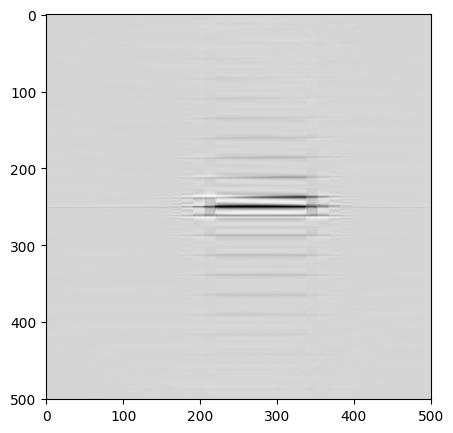

In [46]:
fig5 = plt.figure(5, figsize=[5, 5])

ax_f51 = fig5.add_subplot(1, 1, 1)
ax_f51.imshow(image, cmap='Greys')
